In [ ]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())


Saving disdik-od_17338_jml_siswa_putus_sekolah__jenjang_pendidikan.csv to disdik-od_17338_jml_siswa_putus_sekolah__jenjang_pendidikan.csv
Saving bps-od_persentase_penduduk_miskin_berdasarkan_kategori_wilayah.csv to bps-od_persentase_penduduk_miskin_berdasarkan_kategori_wilayah.csv


['disdik-od_17338_jml_siswa_putus_sekolah__jenjang_pendidikan.csv',
 'bps-od_persentase_penduduk_miskin_berdasarkan_kategori_wilayah.csv']

In [ ]:
import pandas as pd

def read_any(file_name: str) -> pd.DataFrame:
    if file_name.lower().endswith(".csv"):
        return pd.read_csv(file_name)
    if file_name.lower().endswith((".xlsx", ".xls")):
        return pd.read_excel(file_name)
    raise ValueError("Format tidak didukung. Pakai .csv atau .xlsx/.xls")


In [ ]:
FILE_MISKIN = "bps-od_persentase_penduduk_miskin_berdasarkan_kategori_wilayah.csv"
FILE_PUTUS  = "disdik-od_17338_jml_siswa_putus_sekolah__jenjang_pendidikan.csv"

df_putus_raw = read_any(FILE_PUTUS)
df_miskin_raw = read_any(FILE_MISKIN)

print("Putus sekolah columns:", df_putus_raw.columns.tolist())
print("Kemiskinan columns:", df_miskin_raw.columns.tolist())

df_putus_raw.head(), df_miskin_raw.head()


Putus sekolah columns: ['id', 'kode_provinsi', 'nama_provinsi', 'jenjang_pendidikan', 'status_sekolah', 'jumlah_siswa', 'satuan', 'tahun']
Kemiskinan columns: ['id', 'kategori_wilayah', 'persentase_penduduk', 'satuan', 'tahun']


(   id  kode_provinsi nama_provinsi jenjang_pendidikan status_sekolah  \
 0   1             32    JAWA BARAT                SMA         NEGERI   
 1   2             32    JAWA BARAT                SMA         SWASTA   
 2   3             32    JAWA BARAT                SMK         NEGERI   
 3   4             32    JAWA BARAT                SMK         SWASTA   
 4   5             32    JAWA BARAT                SLB         NEGERI   
 
    jumlah_siswa satuan  tahun  
 0          1807  ORANG   2018  
 1          2972  ORANG   2018  
 2          2341  ORANG   2018  
 3         15153  ORANG   2018  
 4            14  ORANG   2018  ,
    id kategori_wilayah  persentase_penduduk  satuan  tahun
 0   1        PERDESAAN                10.25  PERSEN   2018
 1   2        PERKOTAAN                 6.47  PERSEN   2018
 2   3        PERDESAAN                 9.79  PERSEN   2019
 3   4        PERKOTAAN                 6.03  PERSEN   2019
 4   5        PERDESAAN                10.27  PERSEN   2020)

In [ ]:
df_putus = df_putus_raw.copy()

# rapihin nama kolom (jaga-jaga ada spasi)
df_putus.columns = df_putus.columns.astype(str).str.strip()

# pastikan tipe
df_putus["tahun"] = pd.to_numeric(df_putus["tahun"], errors="coerce")
df_putus["jumlah_siswa"] = pd.to_numeric(df_putus["jumlah_siswa"], errors="coerce")

# filter SMA + Jawa Barat
df_putus_sma_jabar = df_putus[
    (df_putus["nama_provinsi"].astype(str).str.upper().str.strip() == "JAWA BARAT") &
    (df_putus["jenjang_pendidikan"].astype(str).str.upper().str.strip() == "SMA")
].copy()

# agregasi: total per tahun (negeri + swasta)
putus_per_tahun = (
    df_putus_sma_jabar
    .groupby("tahun", as_index=False)["jumlah_siswa"]
    .sum()
    .rename(columns={"jumlah_siswa": "putus_sekolah"})
    .sort_values("tahun")
)

putus_per_tahun


,tahun,putus_sekolah
0,2018,4779
1,2019,1147
2,2020,1581


In [ ]:
df_miskin = df_miskin_raw.copy()
df_miskin.columns = df_miskin.columns.astype(str).str.strip()

df_miskin["tahun"] = pd.to_numeric(df_miskin["tahun"], errors="coerce")
df_miskin["persentase_penduduk"] = pd.to_numeric(df_miskin["persentase_penduduk"], errors="coerce")

# rata-rata per tahun (gabungkan PERDESAAN & PERKOTAAN)
miskin_per_tahun = (
    df_miskin
    .groupby("tahun", as_index=False)["persentase_penduduk"]
    .mean()
    .rename(columns={"persentase_penduduk": "kemiskinan_persen"})
    .sort_values("tahun")
)

miskin_per_tahun


,tahun,kemiskinan_persen
0,2018,8.360
1,2019,7.910
2,2020,8.705


In [ ]:
df_final = putus_per_tahun.merge(miskin_per_tahun, on="tahun", how="inner").sort_values("tahun")
df_final


,tahun,putus_sekolah,kemiskinan_persen
0,2018,4779,8.360
1,2019,1147,7.910
2,2020,1581,8.705


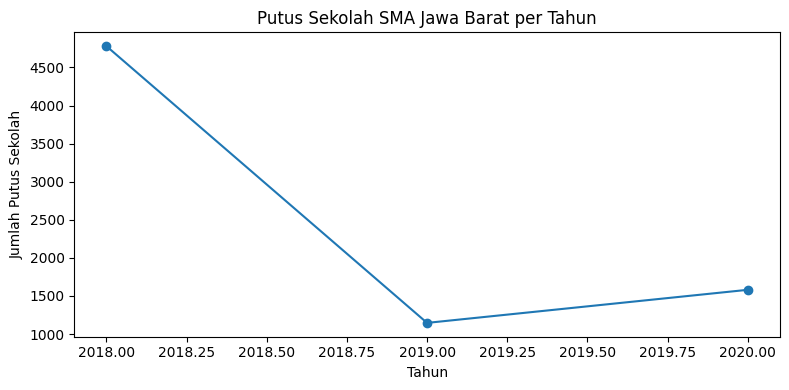

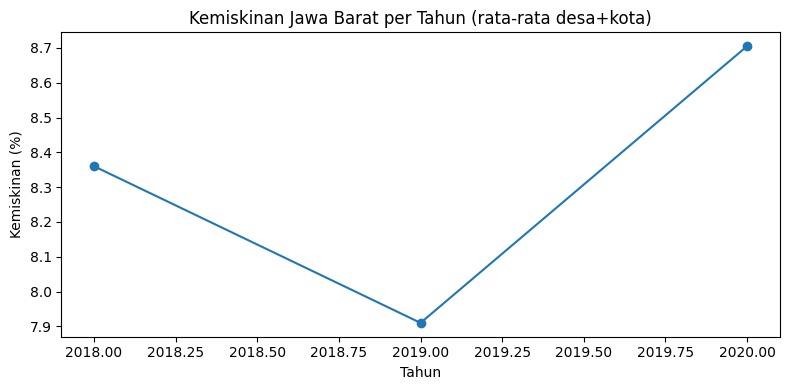

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df_final["tahun"], df_final["putus_sekolah"], marker="o")
plt.title("Putus Sekolah SMA Jawa Barat per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Putus Sekolah")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(df_final["tahun"], df_final["kemiskinan_persen"], marker="o")
plt.title("Kemiskinan Jawa Barat per Tahun (rata-rata desa+kota)")
plt.xlabel("Tahun")
plt.ylabel("Kemiskinan (%)")
plt.tight_layout()
plt.show()


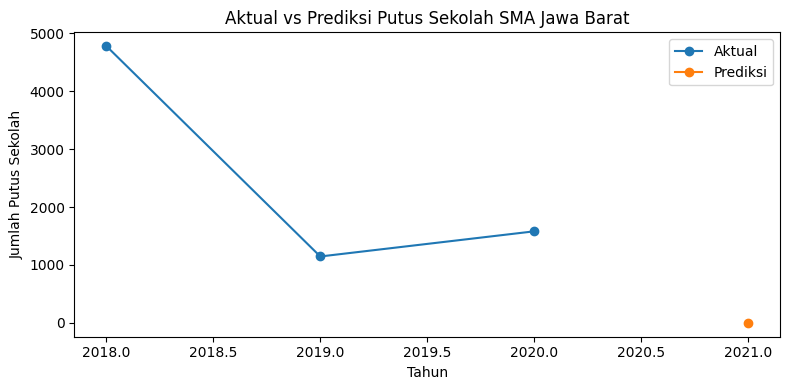

In [19]:
import matplotlib.pyplot as plt

df_plot = pd.concat([
    df_final[["tahun", "putus_sekolah"]].rename(columns={"putus_sekolah": "nilai"}).assign(jenis="Aktual"),
    pred_table[["tahun", "pred_putus_sekolah_safe"]].rename(columns={"pred_putus_sekolah_safe": "nilai"}).assign(jenis="Prediksi")
], ignore_index=True).sort_values("tahun")

plt.figure(figsize=(8,4))
for label, g in df_plot.groupby("jenis"):
    plt.plot(g["tahun"], g["nilai"], marker="o", label=label)
plt.title("Aktual vs Prediksi Putus Sekolah SMA Jawa Barat")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Putus Sekolah")
plt.legend()
plt.tight_layout()
plt.savefig("aktual_vs_prediksi_putus_sekolah_jabar.png", dpi=200)
plt.show()


In [21]:
from google.colab import files

df_final.to_csv("gabungan_jabar_putus_vs_kemiskinan_2018_2020.csv", index=False)
pred_table.to_csv("prediksi_putus_sekolah_jabar_2021.csv", index=False)

files.download("gabungan_jabar_putus_vs_kemiskinan_2018_2020.csv")
files.download("prediksi_putus_sekolah_jabar_2021.csv")
files.download("aktual_vs_prediksi_putus_sekolah_jabar.png")

# kalau kamu bikin grafik PNG di atas:
# files.download("aktual_vs_prediksi_putus_sekolah_jabar.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>